# Fitting Maxima

In this notebook I am going to use the Gaussian process (see nb) to see if I can accurately model the solar cycle maxima.

## Using Scikit-Learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp

In [2]:
df = pd.read_csv('Data/maxima_poly1.csv') # importing maxima data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Solar_Cycle_Maxima).values 
yerr = np.zeros(len(X)) 

df.describe()

,Unnamed: 0,Year,Solar_Cycle_Maxima
count,18.000000,18.000000,18.000000
mean,8.500000,1920.986500,145.702411
std,5.338539,57.920968,44.787446
min,0.000000,1829.316000,86.130732
25%,4.250000,1874.383250,106.273956
50%,8.500000,1922.938500,144.936345
75%,12.750000,1966.279000,178.153149
max,17.000000,2013.525000,242.520192


In [3]:
rng = [np.random.RandomState(4), np.random.RandomState(2), np.random.RandomState(3)] # testing 3 different samples
training_indices = [rng[i].choice(np.arange(y.size), size=10, replace=False) for i in range(len(rng))] 

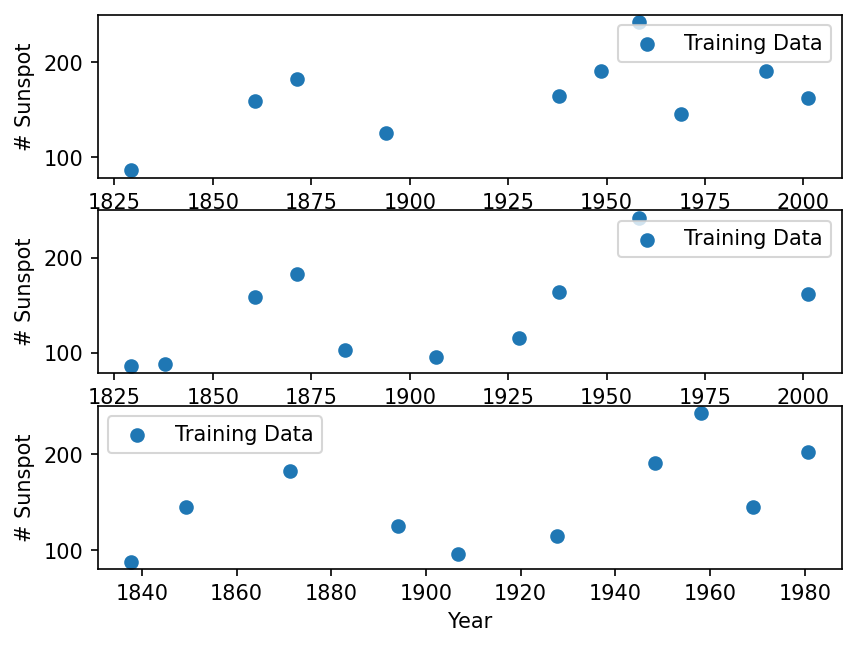

In [4]:
X_train = [X[training_indices[i]] for i in range(len(rng))] # x & y values of random indicies
y_train = [y[training_indices[i]] for i in range(len(rng))]

fig, ax = plt.subplots(len(rng), dpi=150)
for i in range(len(rng)):
    ax[i].scatter(X_train[i], y_train[i], label='Training Data')
    ax[i].set_xlabel('Year')
    ax[i].set_ylabel("# Sunspot")
    ax[i].legend();

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [6]:
length_scale = 100

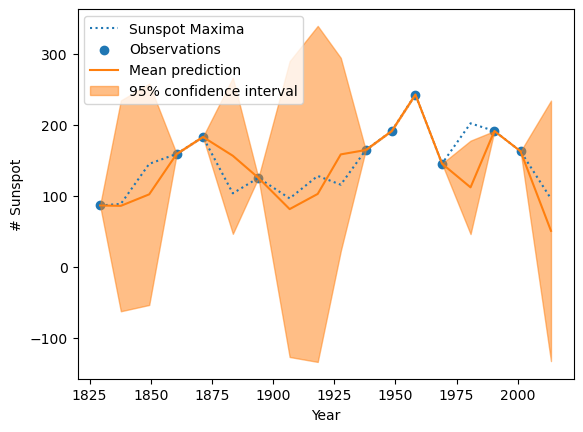

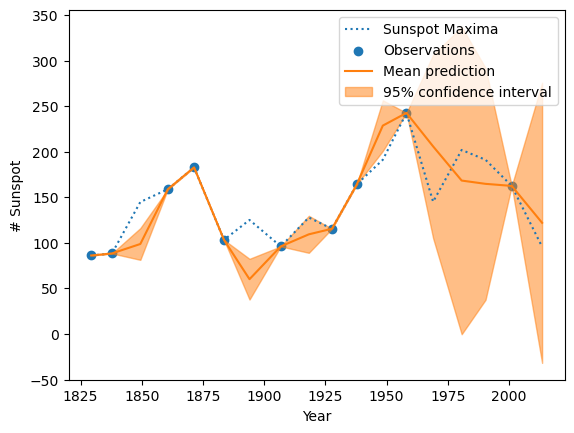

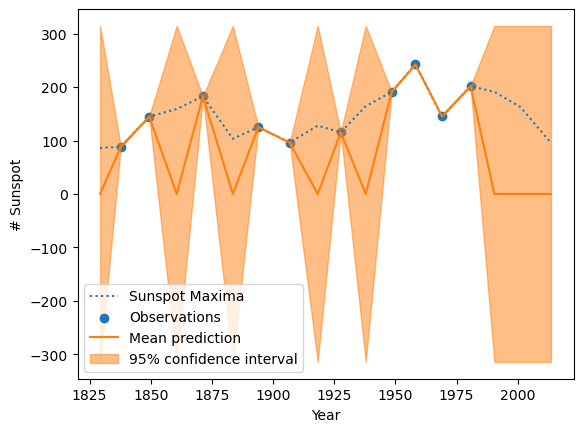

In [7]:
for i in range(len(rng)):
    kernel = 1 * RBF(length_scale=length_scale, length_scale_bounds=(1e-5, 1e+2))
    
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gaussian_process.fit(X_train[i], y_train[i])
    gaussian_process.kernel_
    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
    fig, ax = plt.subplots(dpi=100)
    ax.plot(X, y, label=r"Sunspot Maxima", linestyle='dotted') 
    ax.scatter(X_train[i], y_train[i], label="Observations") # training data
    ax.plot(X, mean_prediction, label="Mean prediction") # gp prediction
    ax.fill_between(
        X.ravel(),
        (mean_prediction - 1.96 * std_prediction), # 95% confidence interval
        (mean_prediction + 1.96 * std_prediction),
        alpha=0.5, color='tab:orange',
        label=r"95% confidence interval",
    )                                                
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel("# Sunspot");

#### Comment on plot:
From the plot above we can see that the GP makes an effort to model the sunspot maxima, but unfortunately it doesnt do a *good enough* job. The 95% intervals are far too large, and the mean predictions don't follow the actual trend as well as they should. 

The problem is our GP is trying to make sure every data point given is exactly modelled by our GP. We could fix this by adding ***white noise*** to our date, so that the GP accounts for some 'wiggle room'.

https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.WhiteKernel.html

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 110.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 110.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 110.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


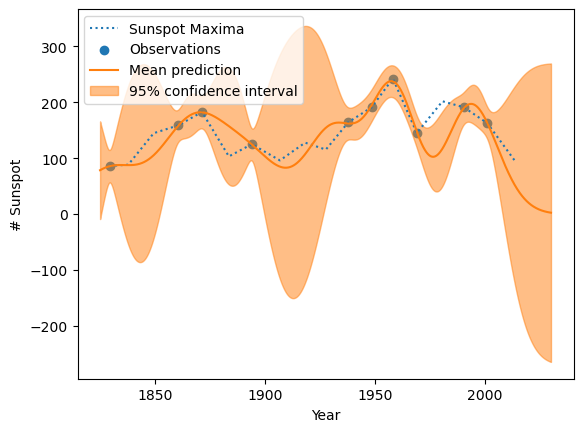

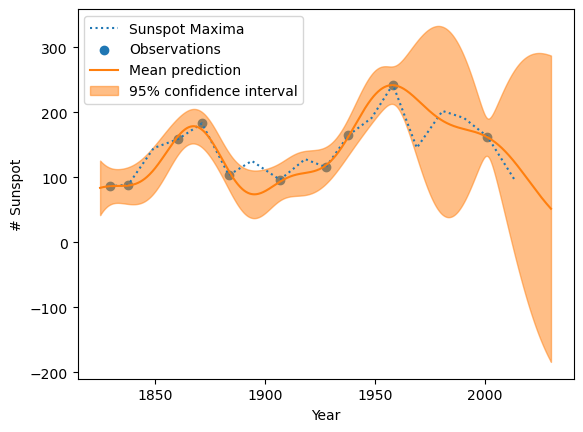

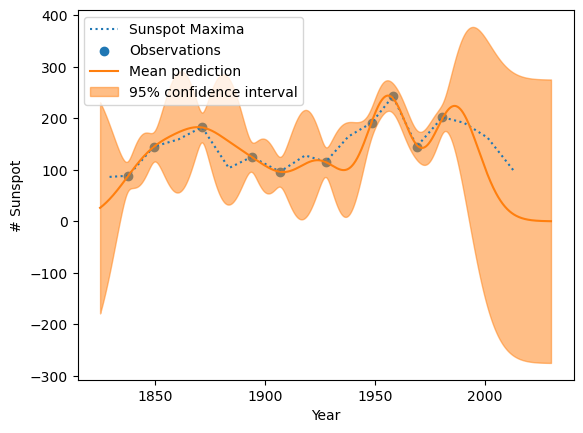

In [8]:
# Adding white noise, and adjusting certain parameters

l = 100
ldelta = 1
w = 1e+2
wdelta = 1e1
X_new = np.linspace(1825, 2030, 1000).reshape(-1,1)
for i in range(len(rng)):
    kernel = 100 * RBF(length_scale=l, length_scale_bounds=(1e-5, 1e+12)) \
                + WhiteKernel(noise_level=w, noise_level_bounds=(w-wdelta, w+wdelta))
    
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gaussian_process.fit(X_train[i], y_train[i])
    gaussian_process.kernel_
    mean_prediction, std_prediction = gaussian_process.predict(X_new, return_std=True)
    fig, ax = plt.subplots(dpi=100)
    ax.plot(X, y, label=r"Sunspot Maxima", linestyle='dotted') 
    ax.scatter(X_train[i], y_train[i], label="Observations") # training data
    ax.plot(X_new, mean_prediction, label="Mean prediction") # gp prediction
    ax.fill_between(
        X_new.ravel(),
        (mean_prediction - 1.96 * std_prediction), # 95% confidence interval
        (mean_prediction + 1.96 * std_prediction),
        alpha=0.5, color='tab:orange',
        label=r"95% confidence interval",
    )                                                
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel("# Sunspot");

#### Comment on plot:

This plot looks much better than the previous one. The Gaussian process creates a much better fitting model. However, if we look at the *future* predictions, we see that there is a very large range of values. This suggests that the solar cycle maxima intensity is *inherently unpredictable*.

## Using PyMC3

Using PyMC3 differs from Sklean in one crucial aspect - here we are *marginalising* our data and sampling to determine the best fitting parameters. 

In [20]:
i = 1 # choosing one sample

In [21]:
with pm.Model() as model:
    length_scale = pm.Deterministic('Length Scale', 
                                    pm.Beta('Length Scale_', 2, 2) * 100 + 1)
    mu = pm.Normal('mu', 130, 50)
    const_func = pm.gp.mean.Constant(mu)
    cov = 150 * pm.gp.cov.ExpQuad(1, length_scale)
    sigma = pm.Beta('$\sigma$', 2, 2)
   
    gp = pm.gp.Marginal(cov_func=cov, mean_func=const_func)  

    s = pm.LogNormal('s', 0, 0.5)
    y_ = gp.marginal_likelihood("y", X=X_train[i], 
                                y=y_train[i], noise=sigma)

    tr = pm.sample(return_inferencedata=True) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, $\sigma$, mu, Length Scale_]


/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'Length Scale_'}>,
        <AxesSubplot:title={'center':'Length Scale'}>],
       [<AxesSubplot:title={'center':'$\\sigma$'}>,
        <AxesSubplot:title={'center':'s'}>, <AxesSubplot:>]], dtype=object)

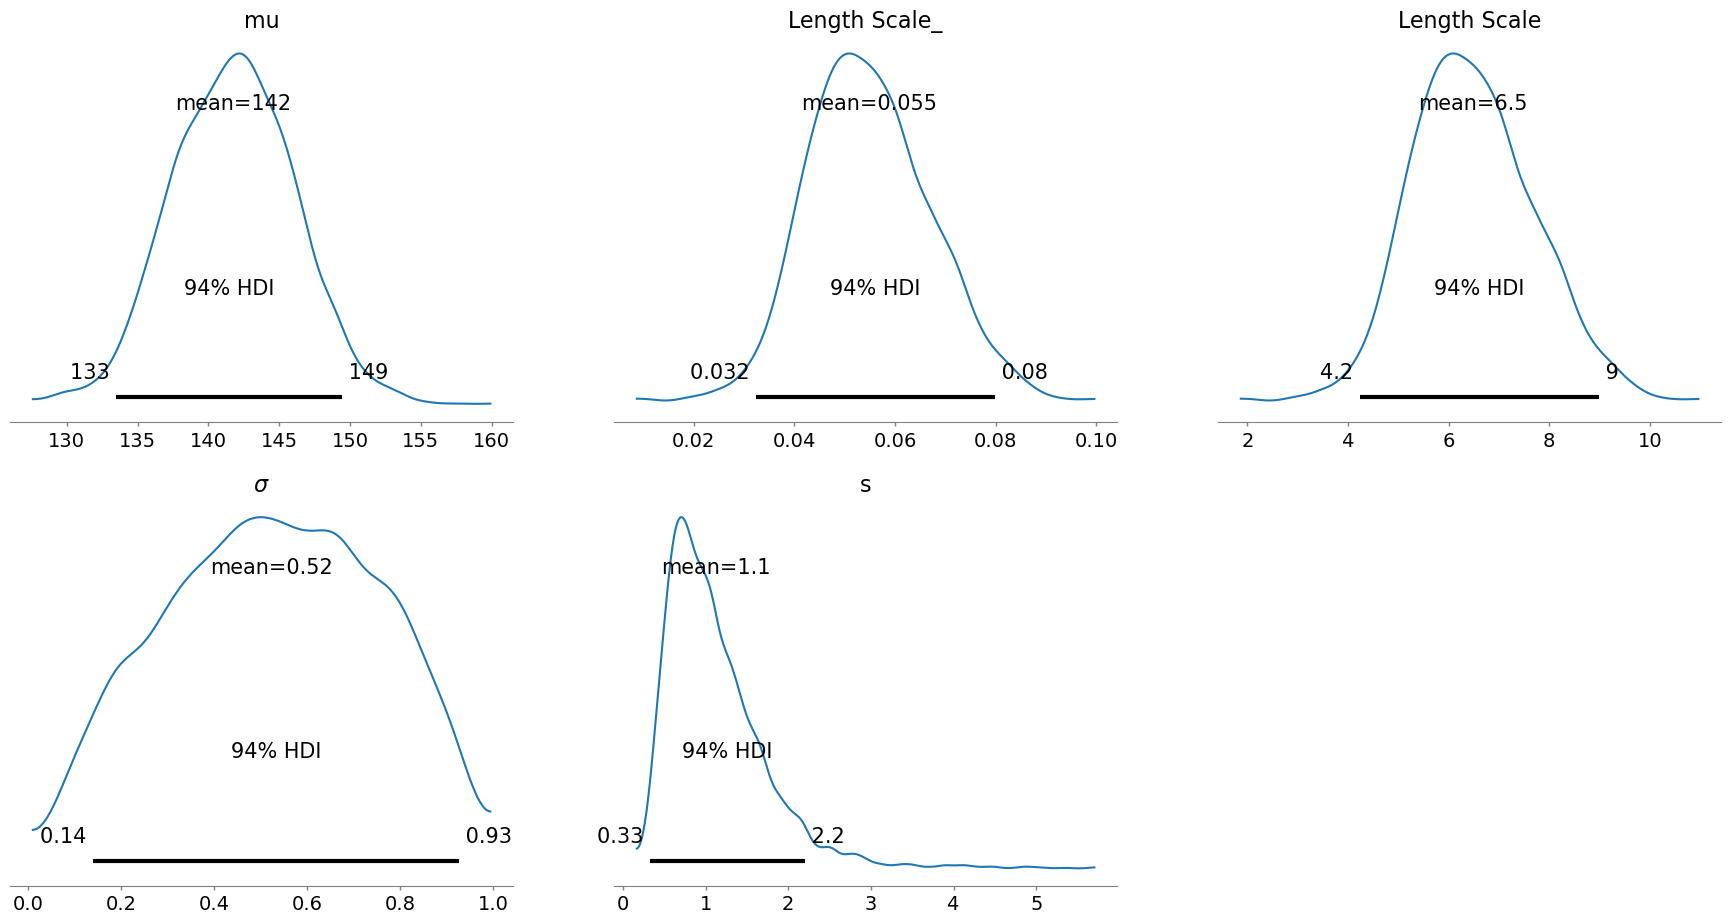

In [22]:
import arviz as az
az.plot_posterior(tr)

#### Comment on plot:

These parameters have been drawn from the sampling done above. We plot the posterior and choose the mean, which is the most ptimal parameter to use.

In [23]:
X_new = np.linspace(1800, 2025, 500)[:, None]
with model:
    fnew = gp.conditional("fnew", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=100, var_names=["fnew"])#

/Applications/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


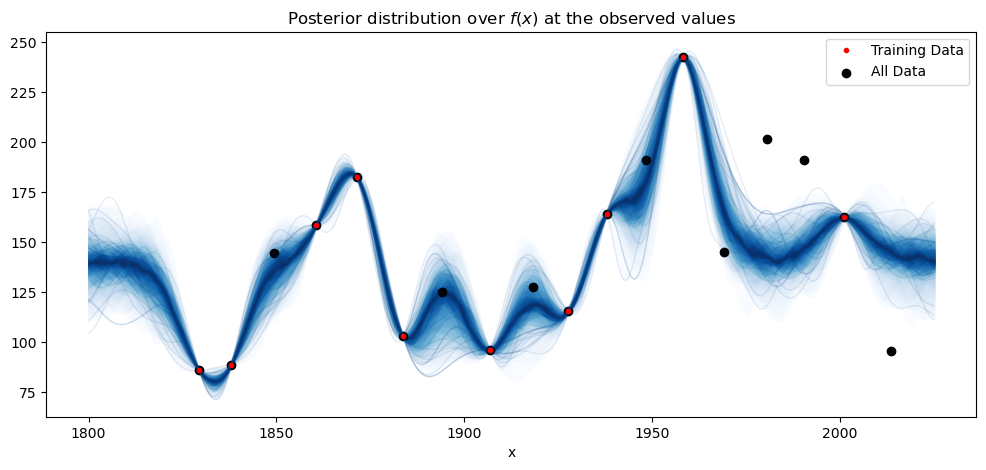

In [24]:
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, ppc['fnew'], X_new, palette="Blues")

# plot original data and true function
plt.plot(X_train[i], y_train[i], "or", ms=3, alpha=1.0, label="Training Data")
plt.scatter(X, y, color="black", label="All Data")

plt.xlabel("x")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

#### Comment on plot:

Using the parameters from the posterior predictive sampler we have plotted our $\mathcal{GP}$ for the maxima. Given how few datapoints it has to work with, it does a very decent job of predicting the shape. I prefer using this method for GPR rather than sklearn.

Notice how the predictive power is non-existent. The GPR simply reverts back to the mean, and so we cannot use this to determine how large our next maxima will be.